# Solving TSP using GA

In [15]:
import numpy as np
import pandas as pd
import networkx as nx
from collections import defaultdict
from haversine import haversine
import matplotlib.pyplot as plt
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.repair import Repair
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import PermutationRandomSampling
from pymoo.operators.crossover.ox import OrderCrossover
from pymoo.operators.mutation.inversion import InversionMutation
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.optimize import minimize

### Define the TSP problem

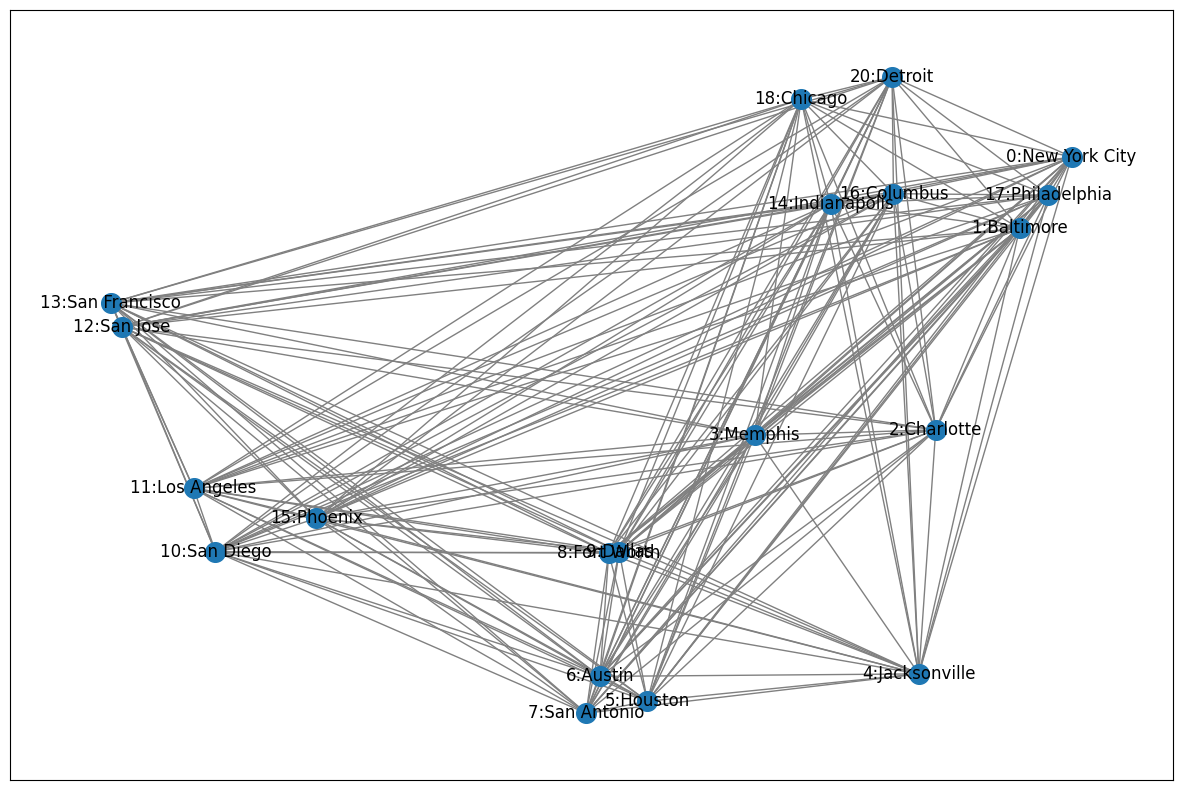

In [23]:
# latitude and longitude for the twenty largest U.S. cities
cities = {
    '0:New York City': (40.72, -74.00),
    '1:Baltimore': (39.28, -76.62),
    '2:Charlotte': (35.23, -80.85),
    '3:Memphis': (35.12, -89.97),
    '4:Jacksonville': (30.32, -81.70),
    '5:Houston': (29.77, -95.38),
    '6:Austin': (30.27, -97.77),
    '7:San Antonio': (29.53, -98.47),
    '8:Fort Worth': (32.75, -97.33),
    '9:Dallas': (32.78, -96.80),
    '10:San Diego': (32.78, -117.15),
    '11:Los Angeles': (34.05, -118.25),
    '12:San Jose': (37.30, -121.87),
    '13:San Francisco': (37.78, -122.42),    
    '14:Indianapolis': (39.78, -86.15),
    '15:Phoenix': (33.45, -112.07),       
    '16:Columbus': (39.98, -82.98),
    '17:Philadelphia': (39.95, -75.17),    
    '18:Chicago': (41.88, -87.63),
    '20:Detroit': (42.33, -83.05)
}

# create a haversine distance matrix based on latitude-longitude coordinates
distance_matrix = defaultdict(dict)
for ka, va in cities.items():
    for kb, vb in cities.items():
        distance_matrix[ka][kb] = 0.0 if kb == ka else haversine((va[0], va[1]), (vb[0], vb[1])) 
        
# convert distance diccionary into a dataframe        
distances = pd.DataFrame(distance_matrix)
city_names=list(distances.columns)
distances=distances.values

# Visualize the cities and then route

# Create a graph
G=nx.Graph()

for ka, va in cities.items():
    for kb, vb in cities.items():
        G.add_weighted_edges_from({(ka,kb, distance_matrix[ka][kb])})
        G.remove_edges_from(nx.selfloop_edges(G))
        
fig, ax = plt.subplots(figsize=(15,10))

# reverse lat and long for correct visualization
reversed_dict = {key: value[::-1] for key, value in cities.items()}

# Create an independent shallow copy of the graph and attributes
H = G.copy()
 
# Draw the network
ax=nx.draw_networkx(
    H,
    pos=reversed_dict,
    with_labels=True,
    edge_color="gray",
    node_size=200,
    width=1,
)

plt.show()
# plt.savefig('CH08_F15_TSP.png', format='png', dpi=300)

In [17]:
class TravelingSalesman(ElementwiseProblem):

    def __init__(self, cities, distances, **kwargs):
        self.cities = cities
        n_cities = len(cities)
        self.distances = distances

        super().__init__(
            n_var=n_cities,
            n_obj=1,
            xl=0,
            xu=n_cities,
            vtype=int,
            **kwargs
        )

    def _evaluate(self, x, out, *args, **kwargs):
        f = 0
        for i in range(len(x) - 1):
            f += distances[x[i], x[i + 1]]
        f += distances[x[-1], x[0]]
        out["F"] = f

In [18]:
class StartFromZeroRepair(Repair):

    def _do(self, problem, X, **kwargs):
        I = np.where(X == 0)[1]

        for k in range(len(X)):
            i = I[k]
            X[k] = np.concatenate([X[k, i:], X[k, :i]])

        return X

### Define GA solver and apply it to solve the problem

In [19]:
problem = TravelingSalesman(cities,distance_matrix)

algorithm = GA(
    pop_size=20,
    sampling=PermutationRandomSampling(),
    mutation=InversionMutation(),
    crossover=OrderCrossover(),
    repair=StartFromZeroRepair(),
    eliminate_duplicates=True
)

# if the algorithm did not improve the last 500 generations then it will terminate (and disable the max generations)
termination = DefaultSingleObjectiveTermination(period=500, n_max_gen=np.inf)

res = minimize(
    problem,
    algorithm,
    termination,
    seed=1,
    verbose=True
)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       20 |  3.570637E+04 |  3.123914E+04
     2 |       40 |  3.162655E+04 |  2.549374E+04
     3 |       60 |  2.890543E+04 |  2.438110E+04
     4 |       80 |  2.673759E+04 |  2.165566E+04
     5 |      100 |  2.492721E+04 |  2.165566E+04
     6 |      120 |  2.321055E+04 |  1.979899E+04
     7 |      140 |  2.209972E+04 |  1.945390E+04
     8 |      160 |  2.180392E+04 |  1.945390E+04
     9 |      180 |  2.158597E+04 |  1.945390E+04
    10 |      200 |  2.077758E+04 |  1.890128E+04
    11 |      220 |  2.038561E+04 |  1.890128E+04
    12 |      240 |  2.002707E+04 |  1.828998E+04
    13 |      260 |  1.975572E+04 |  1.634994E+04
    14 |      280 |  1.952448E+04 |  1.634994E+04
    15 |      300 |  1.923188E+04 |  1.634994E+04
    16 |      320 |  1.898612E+04 |  1.634994E+04
    17 |      340 |  1.839199E+04 |  1.521623E+04
    18 |      360 |  1.827532E+04 |  1.521623E+04
    19 |      380 |  1.779442E+04 |  1.521623E+04


### Print the route and the length

In [20]:
print("Route length:", res.X)
print("Route length:", np.round(res.F[0], 3))
print("Function Evaluations:", res.algorithm.evaluator.n_eval)

Route length: [ 0 16 19 18 14  3  9  8 13 12 11 10 15  7  6  5  4  2  1 17]
Route length: 11005.171
Function Evaluations: 10020


### Visualize the route

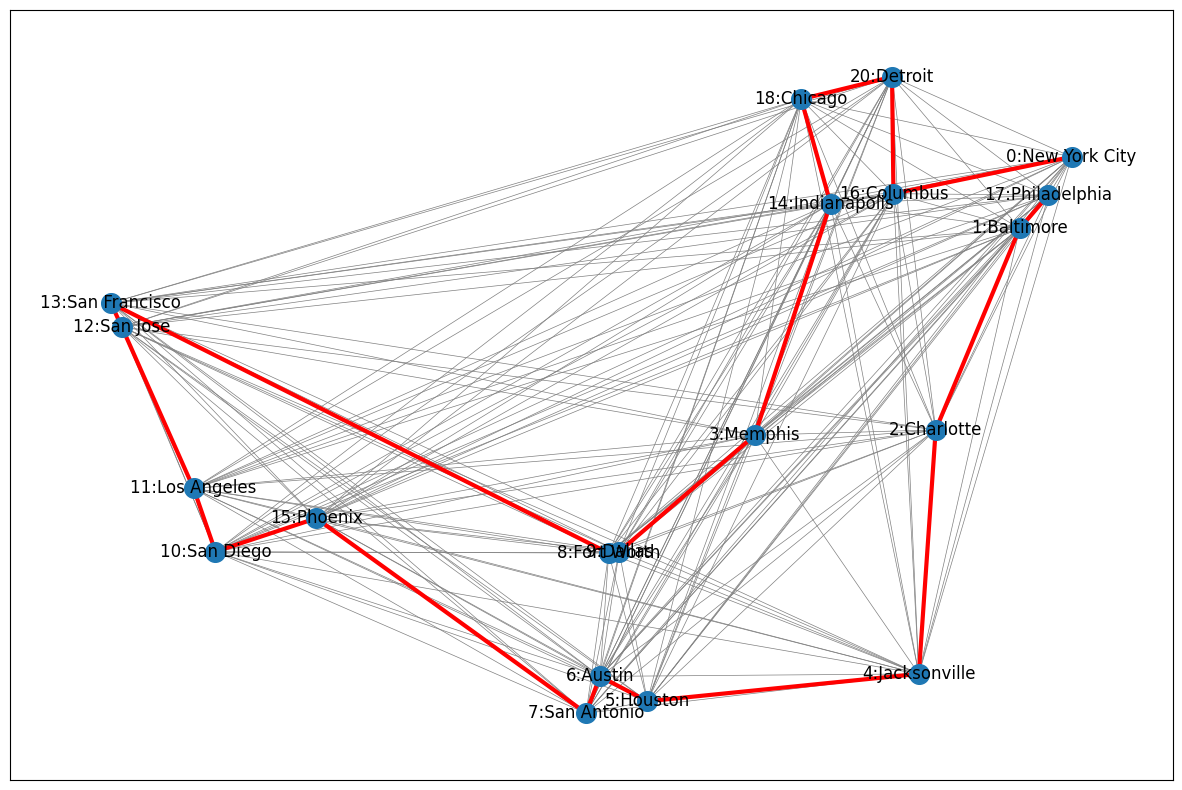

In [25]:
fig, ax = plt.subplots(figsize=(15,10))

# Create an independent shallow copy of the graph and attributes
H = G.copy()

# reverse lat and long for correct visualization
reversed_dict = {key: value[::-1] for key, value in cities.items()}

# Create a list of keys in the original dictionary
keys_list = list(cities.keys())

# Create a new dictionary with the keys in the desired order
included_cities = {keys_list[index]: cities[keys_list[index]] for index in list(res.X)}
included_cities_keys=list(included_cities.keys())

# Create edge list
edge_list =list(nx.utils.pairwise(included_cities_keys))

# Draw closest edges on each node only
nx.draw_networkx_edges(H, pos=reversed_dict, edge_color="gray", width=0.5)

# Draw the route
ax=nx.draw_networkx(
    H,
    pos=reversed_dict,
    with_labels=True,
    edgelist=edge_list,
    edge_color="red",
    node_size=200,
    width=3,
)

plt.show()
# plt.savefig('CH08_F16_TSP_Soln.png', format='png', dpi=300)